In [14]:
import sys  
sys.path.insert(0, '../src/')
import matplotlib.pyplot as plt

import featureExtraction as fe
import numpy as np

import evaluate as ev


WINDOW_SIZE = 256
OVERLAP_FACTOR = 0.5
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [15]:
fe_dataset = fe.FeatureExtractor('ours', WINDOW_SIZE, OVERLAP_FACTOR)
fe_dataset.extract_features()
fe_dataset.standarization()

Loading processed dataset with Window_size=256, Overlap=0.5 and name=ours...
Please wait, this loading could last some minutes...
../data/Window256Overlap0.5/labels.txt - loaded succesfully
../data/Window256Overlap0.5/users.txt - loaded succesfully
../data/Window256Overlap0.5/train.txt - loaded succesfully
../data/Window256Overlap0.5/val.txt - loaded succesfully
../data/Window256Overlap0.5/test.txt - loaded succesfully
../data/Window256Overlap0.5/sensors(145502, 256, 9).txt - loaded succesfully
Extracting features...


100%|██████████| 145502/145502 [00:46<00:00, 3146.65it/s]


Resultant features shape: (145502, 99)
Applying z-score normalization...
Done.


In [16]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from keras.utils import to_categorical

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(fe_dataset.labels.copy())

# Check the order of classes
print("Classes:",label_encoder.classes_)
labels = to_categorical(labels)

Classes: ['Bike' 'Bus' 'Car' 'Metro' 'Moto' 'Run' 'Stationary' 'Train' 'Tram'
 'Walk' 'e-Bike' 'e-Scooter']


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf

def MLP(input, num_neurons=[512, 256, 128], hidden_layers=2, num_classes = 12, act='relu', act_out = 'softmax'):
    layers = []
    layers.append(Dense(num_neurons[0], activation=act, input_shape=[input]))
    for i in range(hidden_layers-1):
        layers.append(Dense(num_neurons[i+1], activation=act))
    layers.append(Dense(num_classes, activation=act_out))
        
    return Sequential(layers)

model = MLP(fe_dataset.features.shape[1], hidden_layers=2,num_neurons=[128, 64])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'] )

history = model.fit(fe_dataset.features[fe_dataset.idx_train], labels[fe_dataset.idx_train], epochs=50, validation_data=(fe_dataset.features[fe_dataset.idx_val], labels[fe_dataset.idx_val]))

Epoch 1/50
3184/3184 [==============================] - 4s 1ms/step - loss: 0.6911 - accuracy: 0.7814 - val_loss: 0.7543 - val_accuracy: 0.7892
Epoch 2/50
3184/3184 [==============================] - 4s 1ms/step - loss: 0.4865 - accuracy: 0.8410 - val_loss: 0.7478 - val_accuracy: 0.8047
Epoch 3/50
3184/3184 [==============================] - 4s 1ms/step - loss: 0.4211 - accuracy: 0.8607 - val_loss: 1.1410 - val_accuracy: 0.7862
Epoch 4/50
3184/3184 [==============================] - 4s 1ms/step - loss: 0.3836 - accuracy: 0.8730 - val_loss: 0.9484 - val_accuracy: 0.7898
Epoch 5/50
3184/3184 [==============================] - 4s 1ms/step - loss: 0.3562 - accuracy: 0.8824 - val_loss: 1.2442 - val_accuracy: 0.7887
Epoch 6/50
3184/3184 [==============================] - 3s 1ms/step - loss: 0.3335 - accuracy: 0.8891 - val_loss: 1.1875 - val_accuracy: 0.7912
Epoch 7/50
3184/3184 [==============================] - 4s 1ms/step - loss: 0.3163 - accuracy: 0.8949 - val_loss: 1.4560 - val_accuracy:

682/682 [==============================] - 1s 719us/step


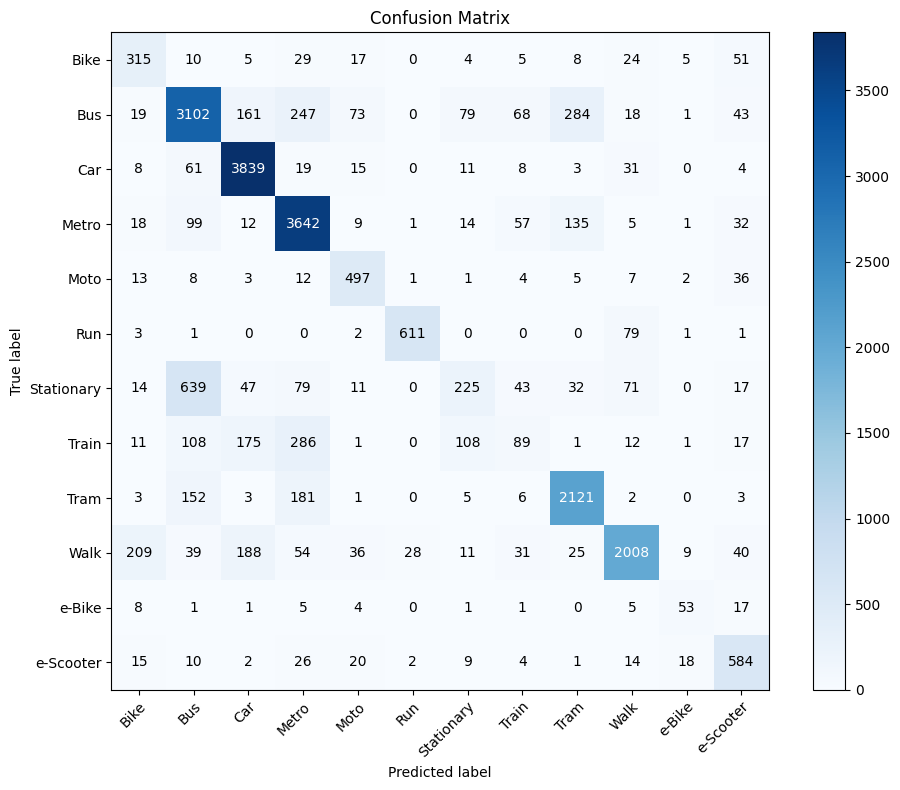

              precision    recall  f1-score   support

        Bike       0.50      0.67      0.57       473
         Bus       0.73      0.76      0.75      4095
         Car       0.87      0.96      0.91      3999
       Metro       0.80      0.90      0.85      4025
        Moto       0.72      0.84      0.78       589
         Run       0.95      0.88      0.91       698
  Stationary       0.48      0.19      0.27      1178
       Train       0.28      0.11      0.16       809
        Tram       0.81      0.86      0.83      2477
        Walk       0.88      0.75      0.81      2678
      e-Bike       0.58      0.55      0.57        96
   e-Scooter       0.69      0.83      0.75       705

    accuracy                           0.78     21822
   macro avg       0.69      0.69      0.68     21822
weighted avg       0.77      0.78      0.77     21822



In [18]:
y_pred = model.predict(fe_dataset.features[fe_dataset.idx_val])
y_pred = np.argmax(y_pred, axis=1)
y_pred = label_encoder.inverse_transform(y_pred)


ev.plot_confusion_matrix(fe_dataset.labels[fe_dataset.idx_val], y_pred)
ev.print_report(fe_dataset.labels[fe_dataset.idx_val], y_pred)

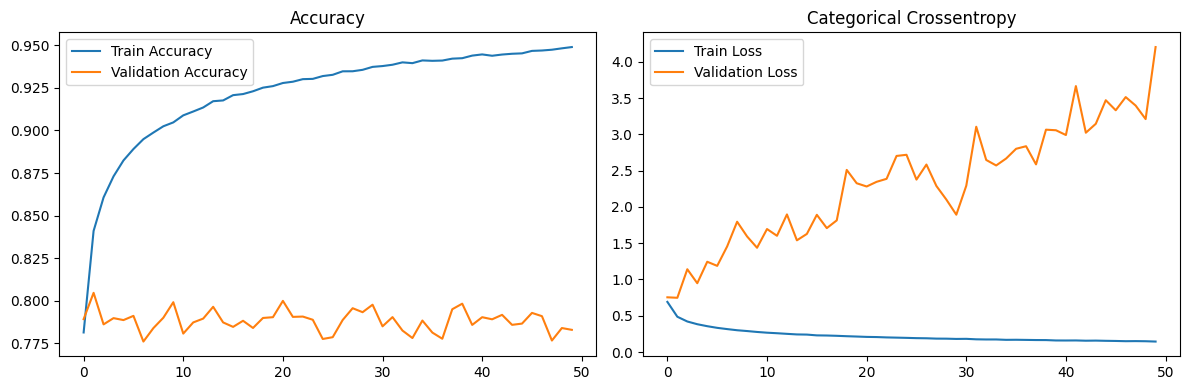

In [19]:
def training_plot(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Categorical Crossentropy')
    plt.legend()

    plt.tight_layout()
    plt.show()

training_plot(history)